# Importacion de las librerias

In [ ]:
# Manejo de datos
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import utils
from sklearn.model_selection import KFold, cross_val_score

# Ploting
import matplotlib.pyplot as plt
import colour

# Algoritmos de ML
import tensorflow as tf
from tensorflow import keras
import scikeras
from sklearn.neighbors import KNeighborsRegressor

# Implementacion de tensorboard
# Load the TensorBoard notebook extension
# %load_ext tensorboard
import datetime
import optuna
from sklearn.metrics import (mean_squared_error, mean_absolute_error, r2_score)

from PIL import Image

     ---------------------------------------- 0.0/47.0 kB ? eta -:--:--
     ------------------------ ------------- 30.7/47.0 kB 660.6 kB/s eta 0:00:01
     -------------------------------------- 47.0/47.0 kB 471.8 kB/s eta 0:00:00


# Lectura y procesamiento del Dataset

In [ ]:
df = pd.read_csv('df_rgb_xyz.csv').drop('Unnamed: 0',axis=1)
df['R'] = df['R'] / 100
df['DEE'] = df['DEE'] / 80
# df['r'] = df['r'] * 255
# df['g'] = df['g'] * 255
# df['b'] = df['b'] * 255
df_test = df
df = df.drop(['x','y','z'], axis=1)
print(df.shape)
df.head()

(24635, 6)


,R,DEE,Remb,r,g,b
0,0.101691,0.891269,0.5481,0.607739,0.607748,0.610636
1,0.249168,0.539952,0.3979,0.614463,0.662313,0.545797
2,0.914374,0.211320,0.6341,0.643678,0.632023,0.563976
3,0.859463,0.568773,0.8010,0.667089,0.649641,0.526636
4,0.311980,0.182830,0.3469,0.752189,0.582688,0.540596


In [ ]:
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
df = df.drop(df[df['r']==df.r.min()].index[0],axis=0)
# plt.violinplot(df.r,vert=False)
df.describe().T

,count,mean,std,min,25%,50%,75%,max
R,24633.0,0.565397,0.284395,0.050000,0.345107,0.560076,0.805031,1.000000
DEE,24633.0,0.474586,0.277204,0.062500,0.233053,0.481493,0.674823,1.000000
Remb,24633.0,0.657976,0.188673,0.300000,0.519618,0.690612,0.775590,1.000000
r,24633.0,0.627975,0.080715,0.237164,0.575010,0.630646,0.685163,0.880922
g,24633.0,0.601234,0.049294,0.363591,0.575145,0.607489,0.629795,0.740896
b,24633.0,0.595487,0.063135,0.280018,0.565934,0.606191,0.632676,0.756195


# Creacion de los datos de entrenamiento de manera aleatoria

In [ ]:
from random import random

test = [(random(), random(), random()) for i in range(1000)]
print(len(test))
test = pd.DataFrame(test)
test.columns=['r','g','b']
test

1000


,r,g,b
0,0.144745,0.635475,0.615023
1,0.508470,0.374683,0.771647
2,0.631336,0.522319,0.739037
3,0.000119,0.644760,0.377239
4,0.809425,0.343366,0.314792
...,...,...,...
995,0.714495,0.818442,0.644032
996,0.807690,0.490866,0.139497
997,0.713888,0.198301,0.252178
998,0.624689,0.298213,0.452791


In [ ]:
knn = KNeighborsRegressor(n_neighbors=1)
knn.fit(df.drop(['R', 'DEE', 'Remb'],axis=1), df[['R', 'DEE', 'Remb']])

# Prediciendo nuevos datos
predictions = knn.predict(test)
test = pd.DataFrame(predictions)
test.columns=('R','DEE','Remb')
test

,R,DEE,Remb
0,0.645693,0.569124,0.357100
1,0.919255,0.896736,0.705899
2,0.799230,0.286757,0.765600
3,0.645693,0.569124,0.357100
4,0.775672,0.532375,0.871967
...,...,...,...
995,0.447626,0.171023,0.590200
996,0.701473,1.000000,0.754851
997,0.837234,0.914796,0.752400
998,0.805229,0.360946,0.802650


In [ ]:
test = pd.merge(test, df[['r', 'g', 'b', 'R', 'DEE', 'Remb']],
                  on=['R', 'Remb', 'DEE'],
                  how='left')
x_test = test.drop(['R', 'DEE', 'Remb'],axis=1)
y_test = test[['R', 'DEE', 'Remb']]
test.head()

,R,DEE,Remb,r,g,b
0,0.645693,0.569124,0.357100,0.237164,0.690736,0.646696
1,0.919255,0.896736,0.705899,0.462458,0.489026,0.756195
2,0.799230,0.286757,0.765600,0.610049,0.503700,0.693513
3,0.645693,0.569124,0.357100,0.237164,0.690736,0.646696
4,0.775672,0.532375,0.871967,0.880922,0.571497,0.417861


In [ ]:
# Unir df1 con df2 usando un 'inner' merge
merged_df = test.merge(df, how='inner')

# Verificar si todas las filas de df1 están en df2
all_rows_present = len(merged_df) == len(test)
all_rows_present

True

# Sustracion de los datos de entramiento del df original

In [ ]:
# Concatenar df1 y df2
concatenated = pd.concat([test, df])

# Eliminar duplicados, manteniendo la primera ocurrencia (es decir, las filas de df1)
concatenated_unique = concatenated.drop_duplicates(keep='first')

# Eliminar las filas que estaban en df1 para obtener el df2 limpio
df = concatenated_unique[~concatenated_unique.index.isin(test.index)]
df.shape

(23370, 6)

In [ ]:
df.shape, test.shape

((23370, 6), (1000, 6))

In [ ]:
# combined_df = pd.concat([test, df])
# filtered_df = combined_df.drop_duplicates(subset=test.columns.tolist(), keep='last')

# Conserva solo las filas que originalmente estaban en df
# df = filtered_df.iloc[len(test):]
x_df = df.drop(['R', 'DEE', 'Remb'],axis=1)
y_df = df[['R', 'DEE', 'Remb']]

In [ ]:
x_df.shape, y_df.shape

((23370, 3), (23370, 3))

# Ubicacion de las muestras en el espacio de color CIIE 1931

C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 2 Degree Standard Observer" has been renamed to "CIE 2015 2 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: The "CIE 2012 10 Degree Standard Observer" has been renamed to "CIE 2015 10 Degree Standard Observer" for consistency with the official CIE name which was adopted in 2015.
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # noqa: B028
C:\Users\DiAl_\anaconda3\envs\DL\Lib\site-packages\colour\utilities\verbose.py:262: ColourUsageWarning: "standalone" argument has been renamed to "show".
  warn(*args, **kwargs)  # n

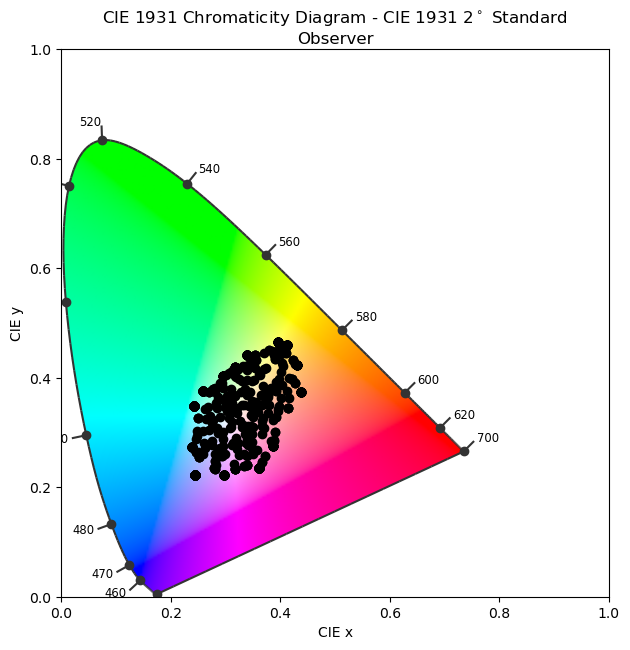

In [ ]:
import colour
df_test = pd.merge(test, df_test[['x', 'y', 'z', 'R', 'DEE', 'Remb']],
                  on=['R', 'Remb', 'DEE'],
                  how='left')
test.head()

# Define your scatter plot points (CIE xy coordinates)
x = df_test['x']
y = df_test['y']

# Plot the CIE 1931 Chromaticity Diagram
colour.plotting.plot_chromaticity_diagram_CIE1931(standalone=False)

# Scatter plot of your points
plt.scatter(x, y, c='black')
# Show the plot
plt.show()

# Entrenamiento de los modelos

# TensorFlow

In [ ]:
# Crear el modelo
model = keras.Sequential([
    keras.layers.Dense(3, input_shape=(3,), activation='elu', kernel_initializer='he_normal',),
    keras.layers.Dense(3, activation='elu', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3, activation='tanh', kernel_initializer='normal'),
    keras.layers.Dense(3, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation='swish', kernel_initializer='normal'),
    keras.layers.Dense(3)
])


optimizer = tf.keras.optimizers.RMSprop(
#     learning_rate=0.001,
#     rho=0.9,
#     momentum=0.5,
#     epsilon=1e-07,
#     centered=True,
#     weight_decay=0.0001,
)

# Compilación del modelo
model.compile(
    optimizer=optimizer,
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsolutePercentageError(),]
)

In [ ]:
# Creacion de la funcion para detener el entrenamiento
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_percentage_error', patience=20)

# Entrenar el modelo y guardar el historial
history = model.fit(x_df,  y_df, epochs=10, validation_data=(x_test, y_test), callbacks=[callback])

Epoch 1/10
731/731 [==============================] - 3s 3ms/step - loss: 0.0918 - mean_absolute_percentage_error: 82.8679 - val_loss: 0.0574 - val_mean_absolute_percentage_error: 35.2520
Epoch 2/10
731/731 [==============================] - 2s 3ms/step - loss: 0.0608 - mean_absolute_percentage_error: 80.9260 - val_loss: 0.0844 - val_mean_absolute_percentage_error: 37.9096
Epoch 3/10
731/731 [==============================] - 2s 3ms/step - loss: 0.0598 - mean_absolute_percentage_error: 79.4795 - val_loss: 0.0890 - val_mean_absolute_percentage_error: 39.1657
Epoch 4/10
731/731 [==============================] - 2s 3ms/step - loss: 0.0593 - mean_absolute_percentage_error: 78.7249 - val_loss: 0.0832 - val_mean_absolute_percentage_error: 39.8357
Epoch 5/10
731/731 [==============================] - 2s 3ms/step - loss: 0.0587 - mean_absolute_percentage_error: 77.9968 - val_loss: 0.0806 - val_mean_absolute_percentage_error: 40.4053
Epoch 6/10
731/731 [==============================] - 2s 3ms

In [ ]:
model.evaluate(test.drop(['R', 'DEE', 'Remb'],axis=1), test[['R', 'DEE', 'Remb']])

32/32 [==============================] - 0s 3ms/step - loss: 0.0746 - mean_absolute_percentage_error: 40.3141


[0.07455836236476898, 40.314109802246094]

In [ ]:
# Graficar el "training loss" y el "validation loss"
plt.figure(figsize=(12, 6))
plt.plot(history.history['mean_absolute_error'], label='Training mean_absolute_error')
plt.plot(history.history['val_mean_absolute_error'], label='Validation/Test mean_absolute_error|')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

# KNRegressor en cascada

In [ ]:
df_R = df.drop(['DEE','Remb'],axis=1)
df_R.head()

In [ ]:
df_DEE = df.drop(['R','Remb'],axis=1)
df_DEE.head()

In [ ]:
df_Remb = df.drop(['DEE','R'],axis=1)
df_Remb.head()

## Data Split en test y training

In [ ]:
# R
df_R = utils.shuffle(df_R, random_state = 10)

R_x_train = df_R.drop(['R'],axis=1)
R_x_test = test[['r','g','b']]
R_y_train = df_R['R']
R_y_test = test['R']
R_x_train.shape,R_x_test.shape

In [ ]:
# DEE
df_DEE = utils.shuffle(df_DEE, random_state = 20)
DEE_x_train = df_DEE.drop(['DEE'],axis=1)
DEE_x_test = test[['r','g','b']]
DEE_y_train = df_DEE['DEE']
DEE_y_test = test['DEE']
DEE_x_train.shape,DEE_x_test.shape

In [ ]:
# Remb
df_Remb = utils.shuffle(df_Remb, random_state = 30)
Remb_x_train = df_Remb.drop(['Remb'],axis=1)
Remb_x_test = test[['r','g','b']]
Remb_y_train = df_Remb['Remb']
Remb_y_test = test['Remb']
Remb_x_train.shape,Remb_x_test.shape

## Parametro Remb

In [ ]:
Remb_model_knn = KNeighborsRegressor(n_neighbors = 36, weights = 'distance', metric = 'manhattan',)
Remb_model_knn.fit(Remb_x_train, Remb_y_train)

In [ ]:
remb_knn_pred = Remb_model_knn.predict(Remb_x_test)
mse = mean_squared_error(Remb_y_test, remb_knn_pred)
mae_1 = mean_absolute_error(Remb_y_test, remb_knn_pred)
print(mse, mae_1)

## Parametro R

In [ ]:
R_x_train['Remb_pred'] = Remb_model_knn.predict(R_x_train)
R_x_test['Remb_pred'] = Remb_model_knn.predict(R_x_test)
R_x_train.head()

In [ ]:
R_model_knn = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', metric = 'manhattan', )
R_model_knn.fit(R_x_train, R_y_train)

In [ ]:
knn_pred = R_model_knn.predict(R_x_test)
mse = mean_squared_error(R_y_test, knn_pred)
mae_2 = mean_absolute_error(R_y_test, knn_pred)
print(mse, mae_2)

## Parametro DEE

In [ ]:
DEE_x_train['Remb_pred'] = Remb_model_knn.predict(DEE_x_train)
DEE_x_test['Remb_pred'] = Remb_model_knn.predict(DEE_x_test)
DEE_x_train['R_pred'] = R_model_knn.predict(DEE_x_train)
DEE_x_test['R_pred'] = R_model_knn.predict(DEE_x_test)
DEE_x_train.head()

In [ ]:
DEE_model_knn = KNeighborsRegressor(n_neighbors = 10, weights = 'distance', metric = 'manhattan',)
DEE_model_knn.fit(DEE_x_train, DEE_y_train)

In [ ]:
dee_knn_pred = DEE_model_knn.predict(DEE_x_test)
mse = mean_squared_error(DEE_y_test, dee_knn_pred)
mae_3 = mean_absolute_error(DEE_y_test, dee_knn_pred)
print(mse, mae_3)

In [ ]:
(mae_1 + mae_2 + mae_3)/3

# KNNR Multivariable

In [ ]:
def objective(trial):

    # Definición de hiperparámetros a optimizar
    n_neighbors = trial.suggest_int('n_neighbors', 2, 40)
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
    metric = trial.suggest_categorical('metric', ['minkowski', 'euclidean', 'manhattan', 'chebyshev'])
    p = 2 if metric != 'minkowski' else trial.suggest_int('p', 1, 5)  # 'p' sólo es relevante para la métrica 'minkowski'
    metric_params = None if metric != 'wminkowski' else {'w': trial.suggest_float('w', 0.0, 1.0)}  # 'w' sólo es relevante para 'wminkowski'

    # Creación del modelo con los hiperparámetros sugeridos
    model_knn = KNeighborsRegressor(
        n_neighbors=n_neighbors,
        weights=weights,
        metric=metric,
        p=p,
        metric_params=metric_params
    )

    # Se utiliza la validación cruzada para evaluar el rendimiento del modelo
    return cross_val_score(model_knn,x_df, y_df, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error').mean()

# Crear un estudio de Optuna y optimizar el estudio
study = optuna.create_study(direction='maximize')  # Maximizar porque estamos usando 'neg_mean_squared_error'
study.optimize(objective, n_trials=100)

# Resultados de la optimización
print(f"Valor óptimo de neg_mean_squared_error: {study.best_value}")
print(f"Mejores hiperparámetros: {study.best_params}")


In [ ]:
knn_m = KNeighborsRegressor(n_neighbors=40, weights='distance', metric='manhattan',)
knn_m.fit(x_df , y_df)


In [ ]:
knn_pred = knn_m.predict(x_test)
mse = mean_squared_error(y_test, knn_pred)
mae = mean_absolute_error(y_test, knn_pred)
print(mse, mae)

**Rango**: 0 ≤ MAE <∞  

In [ ]:
r2_score(y_test, knn_pred)

In [ ]:
array = test[['r','g','b']]


In [ ]:
predict = knn_m.predict(array)

In [ ]:
pred = pd.DataFrame(predict)

In [ ]:
pred

In [ ]:
test[['R','DEE','Remb']]

# Autoencoder Tandem

In [ ]:
input_enc = keras.layers.Input(shape = (x_df.shape[1],))
enc = keras.layers.Dense(3, activation='elu', kernel_initializer='he_normal')(input_enc)
enc = keras.Sequential([
    keras.layers.Dense(3, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dense(3, activation='elu', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation='swish', kernel_initializer='normal'),
    keras.layers.Dense(3)
])(enc)

In [ ]:
input_dec = keras.layers.Input(shape = (3,))
dec = keras.layers.Dense(3, activation='swish', kernel_initializer='normal')(input_dec)
dec  = keras.Sequential([
    keras.layers.Dense(3, activation='swish', kernel_initializer='he_normal'),
    keras.layers.Dense(3, activation='tanh', kernel_initializer='normal'),
    keras.layers.Dense(3, activation='elu', kernel_initializer='lecun_uniform'),
    keras.layers.Dense(3, activation='elu', kernel_initializer='he_uniform'),
    keras.layers.Dense(3)
])(dec)

In [ ]:
encoder = keras.models.Model(input_enc, enc)
decoder = keras.models.Model(input_dec, dec)

autoencoder_input = keras.layers.Input(shape=(3,))
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

autoencoder = keras.models.Model(autoencoder_input, reconstructed)

autoencoder.compile(
    optimizer='Adamax',
    loss=keras.losses.MeanSquaredError(),
    metrics=[keras.metrics.MeanAbsoluteError(),]
)
callback = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_error', patience=10)

In [ ]:
autoencoder.fit(x_df,  y_df, epochs=10, validation_data=(x_test, y_test),callbacks=[callback])

Epoch 1/10
731/731 [==============================] - 7s 5ms/step - loss: 0.1026 - mean_absolute_error: 0.2563 - val_loss: 0.0568 - val_mean_absolute_error: 0.1987
Epoch 2/10
731/731 [==============================] - 3s 4ms/step - loss: 0.0648 - mean_absolute_error: 0.2121 - val_loss: 0.0559 - val_mean_absolute_error: 0.1988
Epoch 3/10
731/731 [==============================] - 3s 4ms/step - loss: 0.0646 - mean_absolute_error: 0.2119 - val_loss: 0.0544 - val_mean_absolute_error: 0.1961
Epoch 4/10
731/731 [==============================] - 3s 4ms/step - loss: 0.0636 - mean_absolute_error: 0.2109 - val_loss: 0.0574 - val_mean_absolute_error: 0.1976
Epoch 5/10
731/731 [==============================] - 3s 4ms/step - loss: 0.0604 - mean_absolute_error: 0.2049 - val_loss: 0.0712 - val_mean_absolute_error: 0.2214
Epoch 6/10
731/731 [==============================] - 3s 3ms/step - loss: 0.0580 - mean_absolute_error: 0.1997 - val_loss: 0.0733 - val_mean_absolute_error: 0.2277
Epoch 7/10
731/7

In [ ]:
autoencoder.evaluate(test.drop(['R', 'DEE', 'Remb'],axis=1), test[['R', 'DEE', 'Remb']])

In [ ]:
def create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8,
                 activation_9, activation_10,  init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6,
                init_mode_7, init_mode_8, init_mode_9, init_mode_10, optimizer):

    input_enc = keras.layers.Input(shape = (x_df.shape[1],))
    enc = keras.layers.Dense(3, activation=activation_1, kernel_initializer=init_mode_1)(input_enc)
    enc = keras.Sequential([
        keras.layers.Dense(3, activation=activation_2, kernel_initializer=init_mode_2),
        keras.layers.Dense(3, activation=activation_3, kernel_initializer=init_mode_3),
        keras.layers.Dense(3, activation=activation_4, kernel_initializer=init_mode_4),
        keras.layers.Dense(3, activation=activation_5, kernel_initializer=init_mode_5),
        keras.layers.Dense(3)
    ])(enc)

    input_dec = keras.layers.Input(shape = (3,))
    dec = keras.layers.Dense(3, activation=activation_6, kernel_initializer=init_mode_6)(input_dec)
    dec  = keras.Sequential([
        keras.layers.Dense(3, activation=activation_7, kernel_initializer=init_mode_7),
        keras.layers.Dense(3, activation=activation_8, kernel_initializer=init_mode_8),
        keras.layers.Dense(3, activation=activation_9, kernel_initializer=init_mode_9),
        keras.layers.Dense(3, activation=activation_10, kernel_initializer=init_mode_10),
        keras.layers.Dense(3)
    ])(dec)

    encoder = keras.models.Model(input_enc, enc)
    decoder = keras.models.Model(input_dec, dec)

    autoencoder_input = keras.layers.Input(shape=(3,))
    encoded_repr = encoder(autoencoder_input)
    reconstructed = decoder(encoded_repr)

    autoencoder = keras.models.Model(autoencoder_input, reconstructed)

    autoencoder.compile(optimizer=optimizer,
                  loss=keras.losses.MeanSquaredError(),
                  metrics=[keras.metrics.MeanAbsoluteError(),])
    return autoencoder

# Función objetivo para Optuna
def objective(trial):
    activations_list = ["elu","exponential","hard_sigmoid","linear", "relu","selu","sigmoid","softmax","softplus",
                                                                                         "softsign","swish","tanh"]
    activation_1 = trial.suggest_categorical('activation_1', activations_list)
    activation_2 = trial.suggest_categorical('activation_2', activations_list)
    activation_3 = trial.suggest_categorical('activation_3', activations_list)
    activation_4 = trial.suggest_categorical('activation_4', activations_list)
    activation_5 = trial.suggest_categorical('activation_5', activations_list)
    activation_6 = trial.suggest_categorical('activation_6', activations_list)
    activation_7 = trial.suggest_categorical('activation_7', activations_list)
    activation_8 = trial.suggest_categorical('activation_8', activations_list)
    activation_9 = trial.suggest_categorical('activation_9', activations_list)
    activation_10 = trial.suggest_categorical('activation_10', activations_list)

    init_list = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    init_mode_1 = trial.suggest_categorical('init_mode_1', init_list)
    init_mode_2 = trial.suggest_categorical('init_mode_2', init_list)
    init_mode_3 = trial.suggest_categorical('init_mode_3', init_list)
    init_mode_4 = trial.suggest_categorical('init_mode_4', init_list)
    init_mode_5 = trial.suggest_categorical('init_mode_5', init_list)
    init_mode_6 = trial.suggest_categorical('init_mode_6', init_list)
    init_mode_7 = trial.suggest_categorical('init_mode_7', init_list)
    init_mode_8 = trial.suggest_categorical('init_mode_8', init_list)
    init_mode_9 = trial.suggest_categorical('init_mode_9', init_list)
    init_mode_10 = trial.suggest_categorical('init_mode_10', init_list)

    optimizer = trial.suggest_categorical('optimizer', ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax',
                                                        'Nadam', 'Ftrl'])
    model = create_model(activation_1, activation_2, activation_3, activation_4, activation_5, activation_6, activation_7, activation_8,
                 activation_9, activation_10,  init_mode_1, init_mode_2, init_mode_3, init_mode_4, init_mode_5, init_mode_6,
                init_mode_7, init_mode_8, init_mode_9, init_mode_10, optimizer)

    history = model.fit(x_df, x_df, epochs=10, validation_split=0.1, verbose=0)

    # Usa la pérdida de validación como métrica para optimizar
    val_loss = history.history['mean_absolute_error'][-1]
    return val_loss

# Iniciar la optimización con Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500)

print("Mejores hiperparámetros:", study.best_params)
